# PAMAP2

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv1D, MaxPool1D, BatchNormalization, Dense,
                                     Input, ReLU, Dropout, LayerNormalization,
                                     MultiHeadAttention, GlobalAveragePooling1D, GRU)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/AI_data/PAMAP2/PAMAP2_integrated_data.csv')

In [4]:
df.head()

,timestamp,activityID,heart_rate,hand_temp,hand_acc_16g_x,hand_acc_16g_y,hand_acc_16g_z,hand_acc_6g_x,hand_acc_6g_y,hand_acc_6g_z,...,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,ankle_orient_1,ankle_orient_2,ankle_orient_3,ankle_orient_4,subject
0,8.38,0.0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,Protocol_subject101
1,8.39,0.0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,Protocol_subject101
2,8.40,0.0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,Protocol_subject101
3,8.41,0.0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,Protocol_subject101
4,8.42,0.0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,Protocol_subject101


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3850505 entries, 0 to 3850504
Data columns (total 55 columns):
 #   Column           Dtype  
---  ------           -----  
 0   timestamp        float64
 1   activityID       float64
 2   heart_rate       float64
 3   hand_temp        float64
 4   hand_acc_16g_x   float64
 5   hand_acc_16g_y   float64
 6   hand_acc_16g_z   float64
 7   hand_acc_6g_x    float64
 8   hand_acc_6g_y    float64
 9   hand_acc_6g_z    float64
 10  hand_gyro_x      float64
 11  hand_gyro_y      float64
 12  hand_gyro_z      float64
 13  hand_mag_x       float64
 14  hand_mag_y       float64
 15  hand_mag_z       float64
 16  hand_orient_1    float64
 17  hand_orient_2    float64
 18  hand_orient_3    float64
 19  hand_orient_4    float64
 20  chest_temp       float64
 21  chest_acc_16g_x  float64
 22  chest_acc_16g_y  float64
 23  chest_acc_16g_z  float64
 24  chest_acc_6g_x   float64
 25  chest_acc_6g_y   float64
 26  chest_acc_6g_z   float64
 27  chest_gyro_x

In [6]:
df = df.drop(columns=['timestamp', 'heart_rate', 'hand_temp', 'hand_acc_6g_x', 'hand_acc_6g_y', 'hand_acc_6g_z', 'hand_orient_1', 'hand_orient_2', 'hand_orient_3', 'hand_orient_4',
                 'chest_temp', 'chest_acc_6g_x', 'chest_acc_6g_y', 'chest_acc_6g_z', 'chest_orient_1', 'chest_orient_2', 'chest_orient_3', 'chest_orient_4', 'ankle_temp', 'ankle_acc_6g_x', 'ankle_acc_6g_y', 'ankle_acc_6g_z',
                 'ankle_orient_1', 'ankle_orient_2', 'ankle_orient_3', 'ankle_orient_4'])

In [7]:
df.isna().sum()

,0
activityID,0
hand_acc_16g_x,14338
hand_acc_16g_y,14338
hand_acc_16g_z,14338
hand_gyro_x,14338
hand_gyro_y,14338
hand_gyro_z,14338
hand_mag_x,14338
hand_mag_y,14338
hand_mag_z,14338


활동(activity)별 데이터프레임 구성 및 NaN 처리
- activityID 0을 제외하고 필요한 활동(집안일 등 생활잡음을 제외한 12개)만 사용
- 활동 별로 fill와 bill을 이용해서 결측값을 처리 -> 활동의 고유한 패턴이 왜곡되지 않도록

In [8]:
activity_mapping = {
        1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6,
        12: 7, 13: 8, 16: 9, 17: 10, 24: 11
    }
df = df[df["activityID"].isin(activity_mapping.keys())]
df["activityID"] = df["activityID"].map(activity_mapping)

# 각 활동(activity)별로 DataFrame을 구성하고, bfill과 ffill을 적용하여 NaN 처리
df_list = []
for activity_id in df['activityID'].unique():
    activity_df = df[df['activityID'] == activity_id].copy()
    # ffill과 bfill을 순차적으로 적용하여 결측치 채우기
    activity_df = activity_df.fillna(method='ffill').fillna(method='bfill')
    # 또는 선형 보간 사용 (linear interpolation)
    # activity_df = activity_df.interpolate(method='linear')
    df_list.append(activity_df)

# 처리된 DataFrame들을 다시 하나로 합치기
df_processed = pd.concat(df_list, ignore_index=True)
df_processed.head()

/tmp/ipython-input-2476589672.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  activity_df = activity_df.fillna(method='ffill').fillna(method='bfill')


,activityID,hand_acc_16g_x,hand_acc_16g_y,hand_acc_16g_z,hand_gyro_x,hand_gyro_y,hand_gyro_z,hand_mag_x,hand_mag_y,hand_mag_z,...,ankle_acc_16g_x,ankle_acc_16g_y,ankle_acc_16g_z,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,subject
0,1.0,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,8.93200,-67.9326,-19.9755,...,9.73855,-1.84761,0.095156,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,Protocol_subject101
1,1.0,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,9.58300,-67.9584,-20.9091,...,9.69762,-1.88438,-0.020804,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,Protocol_subject101
2,1.0,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,9.05516,-67.4017,-19.5083,...,9.69633,-1.92203,-0.059173,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,Protocol_subject101
3,1.0,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,9.92698,-67.4387,-20.5602,...,9.66370,-1.84714,0.094385,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,Protocol_subject101
4,1.0,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,9.15626,-67.1825,-20.0857,...,9.77578,-1.88582,0.095775,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,Protocol_subject101


In [9]:
df.activityID.value_counts()

,count
activityID,
4.0,238761
17.0,238690
1.0,192523
3.0,189931
7.0,188107
2.0,185188
16.0,175353
6.0,164600
12.0,117216


time series 데이터에서 MinMaxScaler를 더 자주 쓰는 이유
- LSTM/GRU는 sigmoid, tanh 같은 함수로 계산되기 때문에 입력이 [0,1], [-1,1]로 정리되어 있는 MinMaxScaler가 선호됨
- StandardScaler는 값이 커지거나 작아질 때 포화 구간에 들어갈 수 있음 -> Gradient Vanishing
- MinMaxScaler는 범위를 0~1로 맞춰서 패턴을 그대로 비교할 수 있음

In [10]:
scaler = MinMaxScaler()
features_to_scale = df_processed.columns.drop(['subject', 'activityID'])
df_processed[features_to_scale] = scaler.fit_transform(df_processed[features_to_scale])

In [11]:
TIME_STEPS = 100
STEPS = 50 # 50% 오버랩

def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

X = df_processed.drop(columns=['activityID', 'subject'])
y = df_processed['activityID'].map(activity_mapping)

# 시퀀스 데이터 생성
X_seq, y_seq = create_dataset(X, y, TIME_STEPS, STEPS)

print(f"변환된 시퀀스 데이터 shape: {X_seq.shape}")
print(f"변환된 레이블 shape: {y_seq.shape}")

변환된 시퀀스 데이터 shape: (38856, 100, 27)
변환된 레이블 shape: (38856, 1)


Stratified(계층적으로)하게 train/val/test split
- stratify: 데이터를 분할할 때 각 서브셋에 클래스의 비율이 동일하게 반영되게끔 함
- e.g. 걷기 50%, 달리기 30%, 자전거 타기 20%라면 훈련/검증/테스트 데이터셋에도 유사한 비율로 반영됨

In [12]:
# train:val:test 비율 -> 80:10:10
test_size = 0.1
val_size = 0.1

# 전체 데이터에서 테스트 셋을 먼저 분리 (stratify=y_seq를 사용하여 클래스 비율 유지)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_seq, y_seq, test_size=test_size, random_state=42, stratify=y_seq
)

# 남은 데이터(훈련+검증)에서 검증 셋을 분리 (stratify=y_train_val를 사용하여 클래스 비율 유지)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_size / (1 - test_size), random_state=42, stratify=y_train_val
)

# 분할된 데이터셋의 최종 크기 확인
print("\n데이터 분할 완료:")
print(f"훈련 셋 크기: X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"검증 셋 크기: X_val.shape = {X_val.shape}, y_val.shape = {y_val.shape}")
print(f"테스트 셋 크기: X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")


데이터 분할 완료:
훈련 셋 크기: X_train.shape = (31084, 100, 27), y_train.shape = (31084, 1)
검증 셋 크기: X_val.shape = (3886, 100, 27), y_val.shape = (3886, 1)
테스트 셋 크기: X_test.shape = (3886, 100, 27), y_test.shape = (3886, 1)


In [13]:
def positional_encoding(length, depth):
    depth = depth/2
    positions = np.arange(length)[:, np.newaxis] # 각 시퀀스 위치 pos 벡터
    depths = np.arange(depth)[np.newaxis, :]/depth # /depth로 정규화,
    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates # broadcasting
    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

In [14]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = int(embed_dim)
        self.num_heads = int(num_heads)
        self.ff_dim = int(ff_dim)
        self.rate = float(rate)

        self.att = MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.embed_dim // self.num_heads
        )
        self.ffn = Sequential([
            Dense(self.ff_dim, activation="relu"),
            Dense(self.embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(self.rate)
        self.dropout2 = Dropout(self.rate)

    def call(self, inputs, training=None):
        attn = self.att(inputs, inputs, training=training)
        x1 = self.layernorm1(inputs + self.dropout1(attn, training=training))
        ffn = self.ffn(x1, training=training)
        return self.layernorm2(x1 + self.dropout2(ffn, training=training))

In [15]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(np.unique(y_train))

def build_model(input_shape, num_classes=6):
    inputs = Input(shape=input_shape)

    # CNN 특징 추출 레이어
    x = Conv1D(128, 5, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool1D(2)(x)
    x = Dropout(0.3)(x)

    x = Conv1D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.3)(x)

    x = GRU(256, return_sequences=True)(x)
    x = Dropout(0.3)(x)

    pos_enc = positional_encoding(x.shape[1], x.shape[2])
    x = x + pos_enc

    x = TransformerBlock(embed_dim=256, num_heads=8, ff_dim=512)(x)

    # Global Average Pooling으로 시퀀스 차원 축소
    x = GlobalAveragePooling1D()(x)

    # 분류 레이어
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

model = build_model(input_shape, num_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 27)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 128)       │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 50, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 50, 256)        │       527,104 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,073,804 (4.10 MB)

 Trainable params: 1,073,036 (4.09 MB)

 Non-trainable params: 768 (3.00 KB)

In [16]:
callbacks = [
            ModelCheckpoint(
                "PAMAP2_CNN_GRU_Transformer_best.weights.h5",
                save_best_only=True,
                save_weights_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=15,
                verbose=1,
                mode='max',
                restore_best_weights=True
            ),
            ReduceLROnPlateau(
                monitor='val_sparse_categorical_accuracy', # val_sparse_categorical_accuracy가 epoch 10 동안 개선되지 않으면
                factor=0.1, # 학습률을 0.1배로 줄임
                patience=10,
                min_lr=0.00001, # 학습률의 최솟값
                verbose=1)
        ]

In [17]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0649 - sparse_categorical_accuracy: 0.6725
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.24858, saving model to PAMAP2_CNN_GRU_Transformer_best.weights.h5
486/486 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - loss: 1.0641 - sparse_categorical_accuracy: 0.6727 - val_loss: 4.0725 - val_sparse_categorical_accuracy: 0.2486 - learning_rate: 0.0010
Epoch 2/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3234 - sparse_categorical_accuracy: 0.9109
Epoch 2: val_sparse_categorical_accuracy improved from 0.24858 to 0.34714, saving model to PAMAP2_CNN_GRU_Transformer_best.weights.h5
486/486 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.3234 - sparse_categorical_accuracy: 0.9110 - val_loss: 4.4864 - val_sparse_categorical_accuracy: 0.3471 - learning_rate: 0.0010
Epoch 3/100
484/486 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2551 - sparse_categorical_accuracy: 0.9268
Epoch 3: val_sparse_categorical_accuracy improved fr

In [19]:
model = build_model(input_shape, num_classes)
model.load_weights("PAMAP2_CNN_GRU_Transformer_best.weights.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 99.75%
Training loss: 0.0072
Test accuracy: 98.97%
Test loss: 0.0535


In [20]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9974    0.9922    0.9948       385
           1     0.9918    0.9838    0.9878       370
           2     0.9668    0.9947    0.9805       380
           3     0.9958    0.9937    0.9948       478
           4     0.9949    1.0000    0.9975       196
           5     0.9970    0.9970    0.9970       329
           6     0.9973    0.9973    0.9973       376
           7     0.9871    0.9787    0.9829       235
           8     0.9904    0.9857    0.9881       210
           9     0.9690    0.9801    0.9745       351
          10     0.9958    0.9832    0.9895       477
          11     1.0000    0.9899    0.9949        99

    accuracy                         0.9897      3886
   macro avg     0.9903    0.9897    0.9900      3886
weighted avg     0.9898    0.9897    0.9897      3886



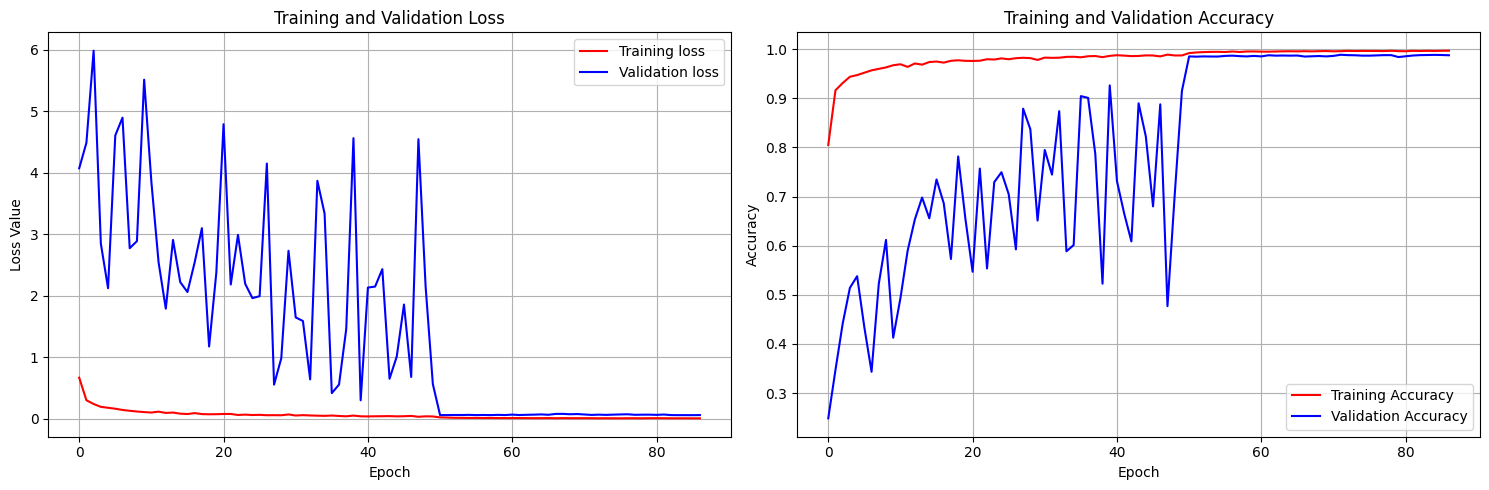

In [21]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

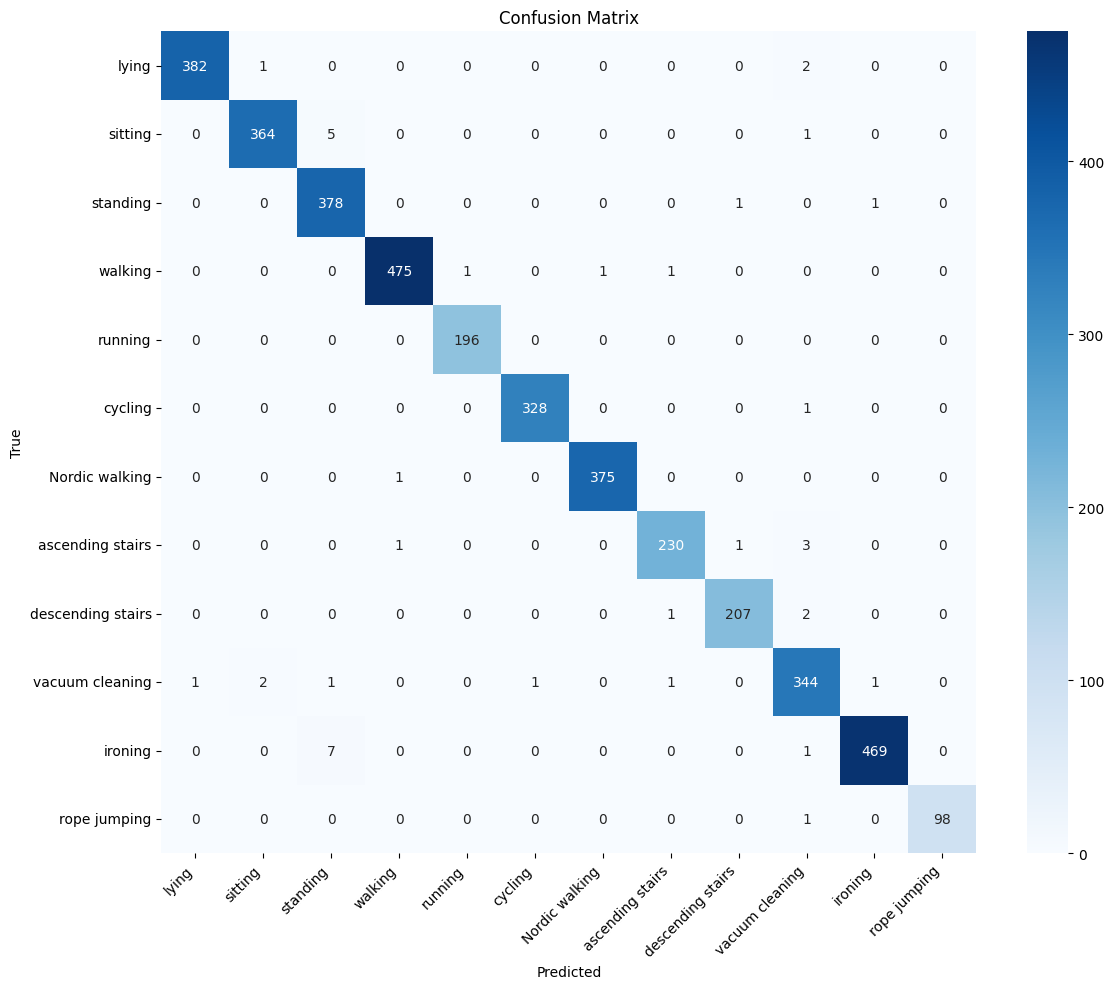

In [22]:
LABELS = ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling', 'Nordic walking', 'ascending stairs', 'descending stairs', 'vacuum cleaning', 'ironing', 'rope jumping']

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')


if num_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:num_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:num_classes], rotation=0)

plt.tight_layout()
plt.show()